In [1]:
%matplotlib inline

import numpy as np
# from bokeh.plotting import figure, show, output_file
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

In [2]:
df_La_Jolla_S = pd.read_csv("csv_data/By-Location/La_Jolla_Campus__S_Parking_Spaces.csv")
df_La_Jolla_S.head()

,year,quarter,parking_spaces,8am,9am,10am,11am,12pm,1pm,2pm,3pm,4pm,5pm,peak_empty_spaces,peak_occupied_spaces,%_occupied
0,2000/01,Summer,6474.0,4882.0,4507.0,4149.0,3929.0,4041.0,4104.0,4149.0,4236.0,4387.0,4642.0,3929.0,2545.0,0.39
1,2000/01,Fall,6527.0,3713.0,2842.0,1815.0,1165.0,989.0,935.0,1024.0,1377.0,1738.0,2422.0,935.0,5592.0,0.86
2,2000/01,Winter,7203.0,4196.0,3280.0,2466.0,1881.0,1675.0,1588.0,1622.0,1931.0,2363.0,3060.0,1588.0,5615.0,0.78
3,2000/01,Spring,7205.0,4267.0,3306.0,2570.0,1962.0,1714.0,1636.0,1712.0,2003.0,2354.0,2980.0,1636.0,5569.0,0.77
4,2001/02,Summer,7243.0,5646.0,5228.0,4789.0,4533.0,4603.0,4689.0,4693.0,4751.0,4839.0,5054.0,4533.0,2710.0,0.37


In [3]:
s = ['8am','9am','10am','11am','12pm','1pm','2pm','3pm','4pm','5pm']
df_temp = df_La_Jolla_S.drop(columns = s, axis = 1)

df_temp = df_temp.join(df_La_Jolla_S[s].stack().reset_index(level = 1, drop = True).rename('empty_spaces'))
df_temp = df_temp.reset_index(drop = True)

time_list = [s[i % 10] for i in range(0,600)]
df_temp['time'] = time_list

df_temp['date'] = df_temp['year']+ " " +df_temp['quarter']

In [4]:
df_temp.head()

,year,quarter,parking_spaces,peak_empty_spaces,peak_occupied_spaces,%_occupied,empty_spaces,time,date
0,2000/01,Summer,6474.0,3929.0,2545.0,0.39,4882.0,8am,2000/01 Summer
1,2000/01,Summer,6474.0,3929.0,2545.0,0.39,4507.0,9am,2000/01 Summer
2,2000/01,Summer,6474.0,3929.0,2545.0,0.39,4149.0,10am,2000/01 Summer
3,2000/01,Summer,6474.0,3929.0,2545.0,0.39,3929.0,11am,2000/01 Summer
4,2000/01,Summer,6474.0,3929.0,2545.0,0.39,4041.0,12pm,2000/01 Summer


In [17]:
spaces_data.head()

date,2000/01 Fall,2000/01 Spring,2000/01 Summer,2000/01 Winter,2001/02 Fall,2001/02 Spring,2001/02 Summer,2001/02 Winter,2002/03 Fall,2002/03 Spring,...,2012/13 Summer,2012/13 Winter,2013/14 Fall,2013/14 Spring,2013/14 Summer,2013/14 Winter,2014/15 Fall,2014/15 Spring,2014/15 Summer,2014/15 Winter
time,,,,,,,,,,,,,,,,,,,,,
10am,1815.0,2570.0,4149.0,2466.0,2128.0,2355.0,4789.0,2165.0,1876.0,2189.0,...,2955.0,1616.0,1298.0,1361.0,2872.0,1394.0,1112.0,1214.0,2422.0,1055.0
11am,1165.0,1962.0,3929.0,1881.0,1473.0,1700.0,4533.0,1438.0,1188.0,1453.0,...,2741.0,1373.0,1042.0,1063.0,2649.0,1140.0,821.0,913.0,2224.0,704.0
12pm,989.0,1714.0,4041.0,1675.0,1295.0,1360.0,4603.0,1177.0,1001.0,1191.0,...,2688.0,1291.0,970.0,907.0,2557.0,1013.0,684.0,787.0,2161.0,619.0
1pm,935.0,1636.0,4104.0,1588.0,1241.0,1171.0,4689.0,1075.0,990.0,1012.0,...,2724.0,1258.0,858.0,868.0,2599.0,944.0,634.0,677.0,2190.0,677.0
2pm,1024.0,1712.0,4149.0,1622.0,1264.0,1185.0,4693.0,1102.0,1010.0,873.0,...,2696.0,1189.0,838.0,866.0,2561.0,894.0,593.0,695.0,2215.0,642.0


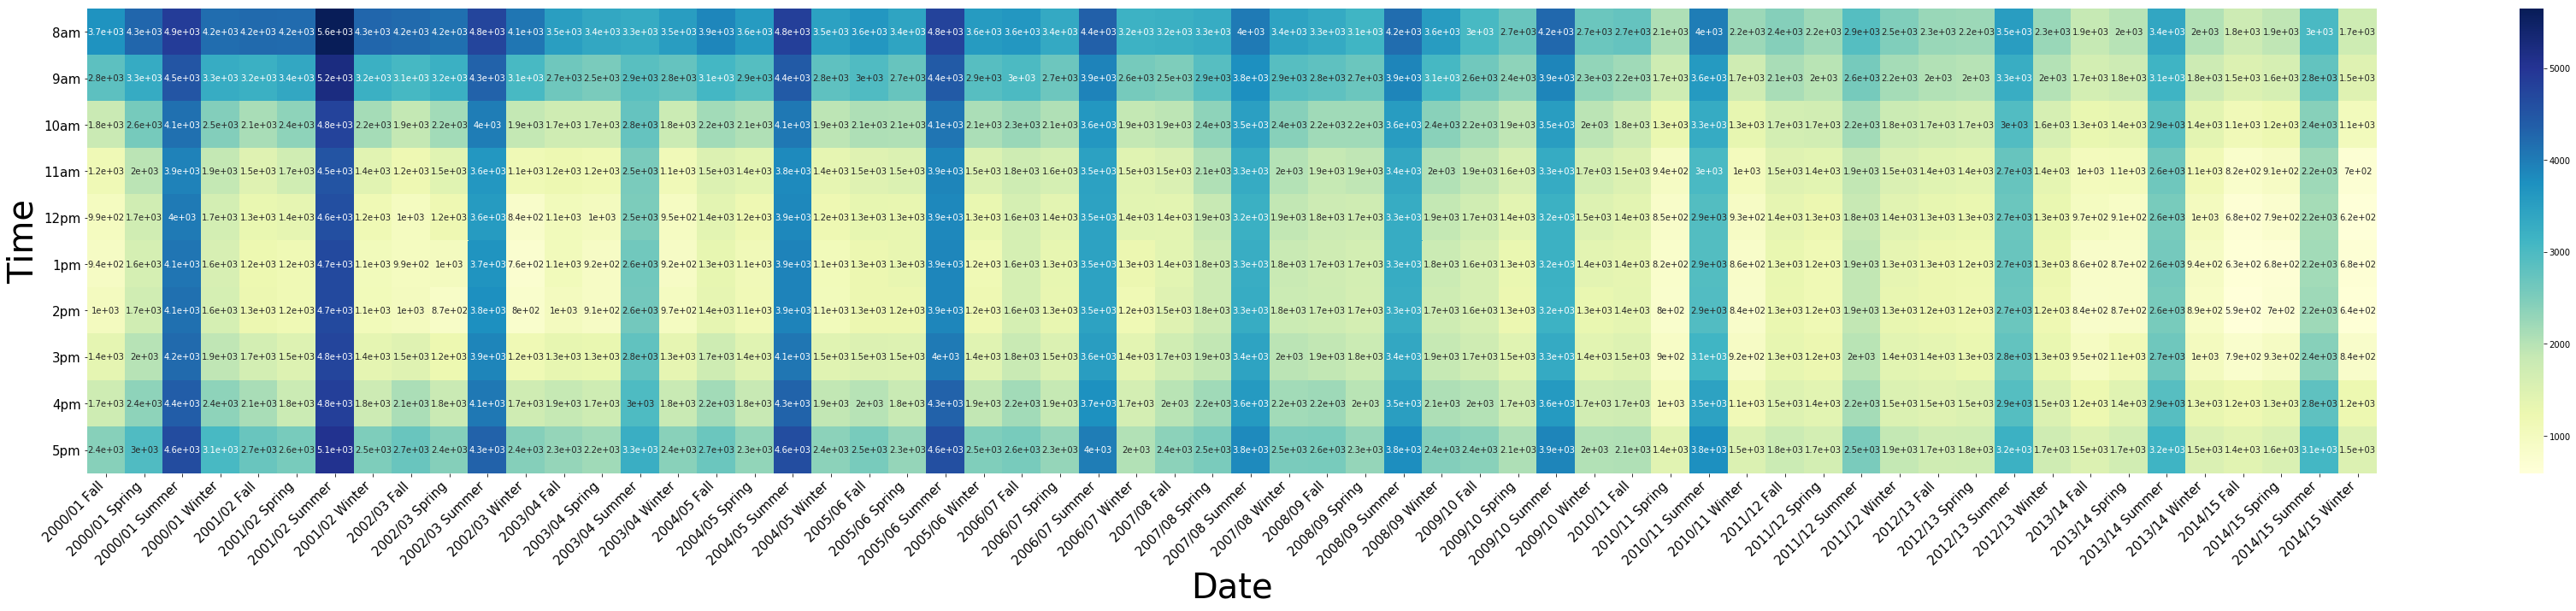

In [33]:
spaces_data = df_temp.pivot('time','date','empty_spaces').reindex(s)
f, ax = plt.subplots(figsize=(60, 10))
sns.heatmap(spaces_data,annot=True, cmap='YlGnBu',ax=ax)

label_y = ax.get_yticklabels()
plt.setp(label_y, rotation=360, horizontalalignment='right',fontsize = 15)
label_x = ax.get_xticklabels()
plt.setp(label_x, rotation=45, horizontalalignment='right',fontsize = 15)
plt.xlabel('Date', fontsize = 40)
plt.ylabel('Time', fontsize = 40)
# plt.savefig('emptyspaces_heatmap_LaJollaCampusS.png')
plt.show()